In [1]:
options(repr.plot.width=14, repr.plot.height=6)

# The Problem of Correlated Errors


## Least-squares is No Longer BLUE

## Correlation Affects the Standard Errors

### Theory

### Simulation

#### Positive Correlation
To see this, we can run a simulation in `R`. First, we use the `mvrnorm()` function from the `MASS` package to simulate 1,000 realisations of two repeated measurements with a correlation of $\rho = 0.8$. To do this, we use the following sampling model:

$$
\begin{bmatrix}
    y_{i1} \\
    y_{i2} \\
\end{bmatrix}
\sim\mathcal{N}\left(
\begin{bmatrix}
    0 \\
    0 \\
\end{bmatrix},
\begin{bmatrix}
    1 & 0.8 \\
    0.8 & 1 \\
\end{bmatrix}
\right)
$$

We can think of this as the data for subject $i$ being drawn from a 2-dimensional normal distribution, where each dimension represents one of the repeated measurements. The mean vector is $\boldsymbol{\mu} = \left[0, 0\right]$, so there is no average difference between the conditions[^foot1]. The variance-covariance matrix is then given by

$$
\boldsymbol{\Sigma} = 
\begin{bmatrix}
    1 & 0.8 \\
    0.8 & 1 \\
\end{bmatrix},
$$

such that $\sigma^{2}_{y_{i1}} = \sigma^{2}_{y_{i2}} = 1$ and the covariance is $\text{Cov}\left(y_{i1},y_{i2}\right) = \rho\sigma_{y_{i1}}\sigma_{y_{i2}} = \rho = 0.8$. The `R` code is then:

In [ ]:
library(MASS)
set.seed(666) # For reproducibility

var1  <- 1                         # Variance of condition 1
var2  <- 1                         # Variance of condition 2
rho   <- 0.8                       # Correlation between conditions 1 & 2
covar <- rho*sqrt(var1)*sqrt(var2) # Covariance between conditions 1 & 2

Sigma_dep <- matrix(c(var1,covar,covar,var2),2,2)
y_dep     <- mvrnorm(n=1000, mu=c(0,0), Sigma=Sigma_dep)

head(y_dep)

1.6769432,2.0023640
2.4163856,3.6555836
0.9533732,0.6228066
3.2847309,2.8134470
-1.0917971,-0.8644265
1.5962354,2.0927202


The result of this is that we have simulated 1,000 pairs of data-points that are correlated. You can think of this like sampling 1,000 subjects, where each subject provides a pair of correlated measurements (such as a score from two different within-subject conditions of a task).

We can compare this with a similar situation where there is *no* correlation between the measurements, i.e.

$$
\boldsymbol{\Sigma} = 
\begin{bmatrix}
    1 & 0 \\
    0 & 1 \\
\end{bmatrix}.
$$

Because all the measurements are independent, we do not really need the `mvrnorm()` function, but we keep it here for consistency. The `R` code would be:

In [ ]:
rho   <- 0             
covar <- rho*sqrt(var1)*sqrt(var2)

Sigma_indep <- matrix(c(var1,covar,covar,var2),2,2)
y_indep     <- mvrnorm(n=1000, mu=c(0,0), Sigma=Sigma_indep)

head(y_indep)

0.4622059,1.7908571
0.3294882,-1.0690040
2.0993015,0.7124285
0.8127087,2.9085131
1.3117156,2.0340054
2.6482554,-0.2137198


In both cases, we conceptualise the columns as representing two different conditions of an experiment. As such, our interest lies in the *difference* between the columns. So, as a final step, we subtract the columns and then compare the distributions of differences.

[1] 0.08789985 0.20085288

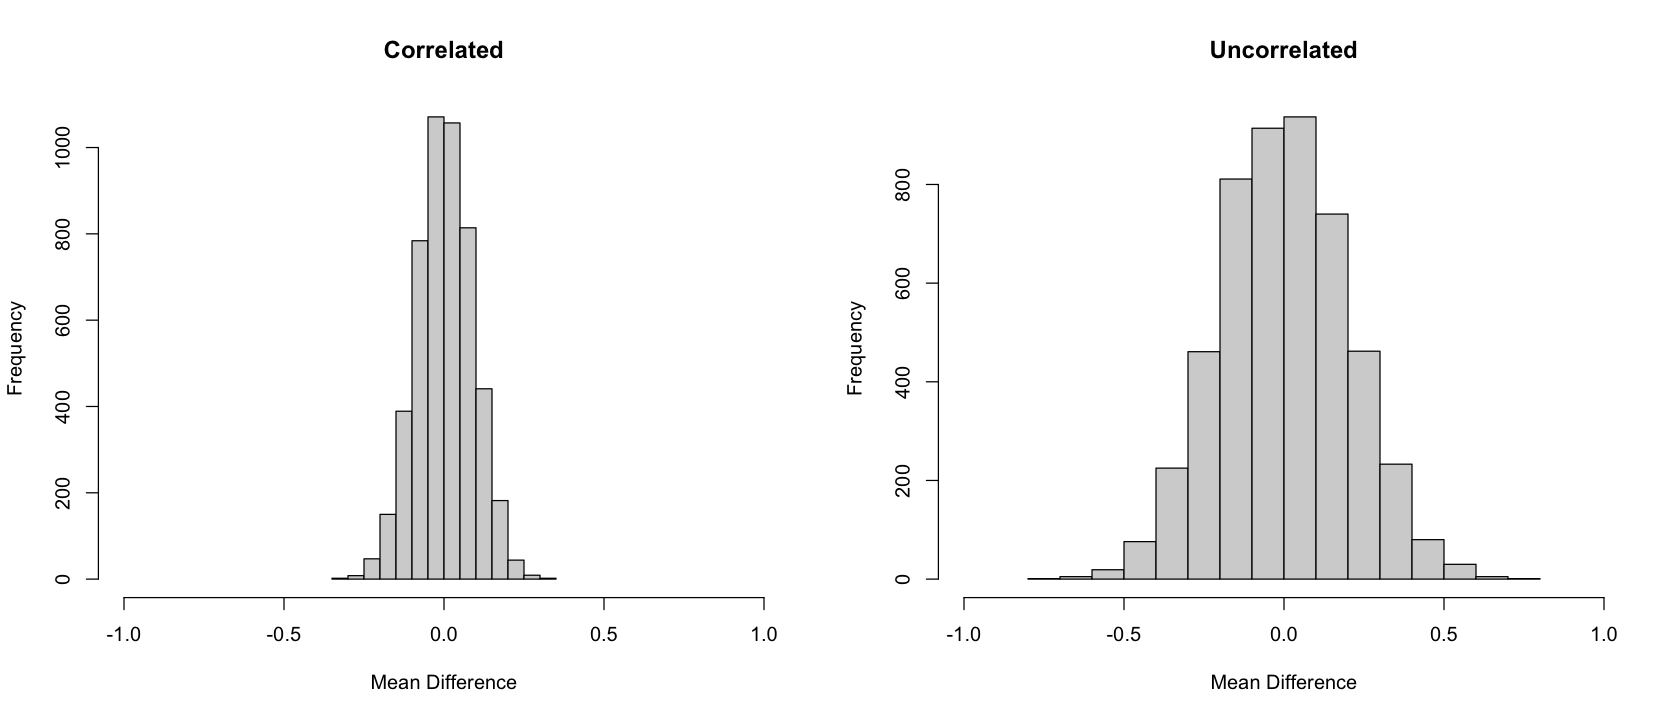

In [18]:
mu_diff_dep   <- rep(0,5000)
mu_diff_indep <- rep(0,5000)

for(i in 1:5000){
    y_indep <- mvrnorm(n=50, mu=c(0,0), Sigma=Sigma_indep)
    y_dep   <- mvrnorm(n=50, mu=c(0,0), Sigma=Sigma_dep)
    mu_diff_indep[i] <- mean(y_indep[,1]) -  mean(y_indep[,2])
    mu_diff_dep[i]   <- mean(y_dep[,1])   -  mean(y_dep[,2])
}

par(mfrow=c(1,2))
hist(mu_diff_dep,   xlim=c(-1,1), xlab='Mean Difference', main='Correlated')
hist(mu_diff_indep, xlim=c(-1,1), xlab='Mean Difference', main='Uncorrelated')

c(sd(mu_diff_dep),sd(mu_diff_indep))

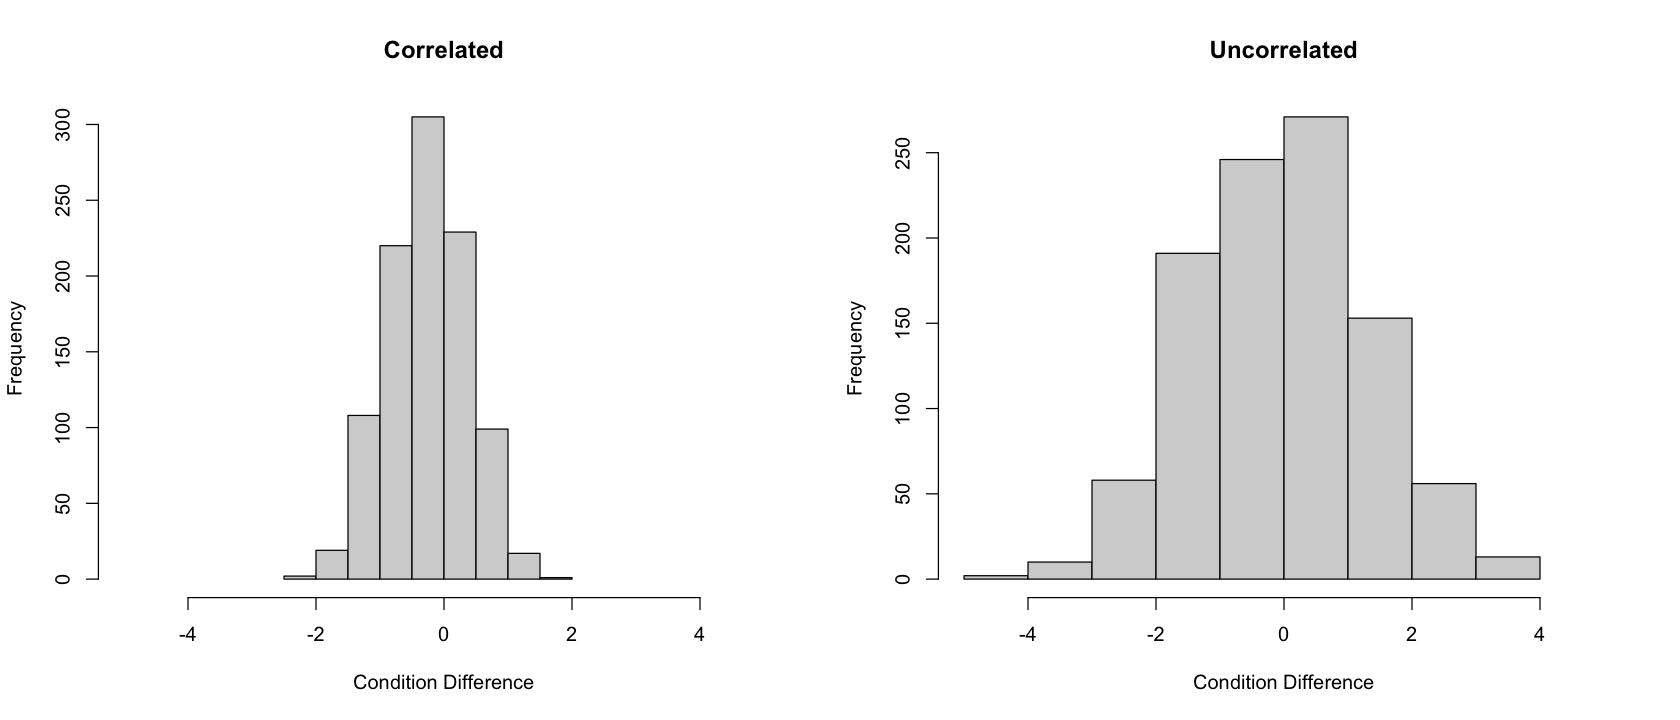

In [8]:
y_diff_dep   <- y_dep[,1]   - y_dep[,2]
y_diff_indep <- y_indep[,1] - y_indep[,2]

par(mfrow=c(1,2))
hist(y_diff_dep,   xlim=c(-5,5), xlab='Condition Difference', main='Correlated')
hist(y_diff_indep, xlim=c(-5,5), xlab='Condition Difference', main='Uncorrelated')

According to the theory above, the standard error of these distributions can be calculated as $\sqrt{\sigma^{2}_{y_{i1}} + \sigma^{2}_{y_{i2}} - 2\text{Cov}\left(\sigma^{2}_{y_{i1}},\sigma^{2}_{y_{i2}}\right)}$. For the correlated data, we can compare this theoretical standard error to the one estimated from the simulations:

In [9]:
rho   <- 0.8           
covar <- rho*sqrt(var1)*sqrt(var2)

SE_dep_theory <- sqrt(var1 + var2 - 2*covar)
SE_dep_est    <- sd(y_diff_dep)
round(c(SE_dep_theory,SE_dep_est), digits=3)

[1] 0.632 0.630

For the uncorrelated data, this is

In [10]:
rho   <- 0 
covar <- rho*sqrt(var1)*sqrt(var2) 

SE_indep_theory <- sqrt(var1 + var2 - 2*covar)
SE_indep_est    <- sd(y_diff_indep)
round(c(SE_indep_theory,SE_indep_est), digits=3)

[1] 1.414 1.364

From this, we can conclude that the theory seems to be an accurate representation of reality, *and* most importantly, that positively correlated data leads to a *much smaller* standard error.

We can see how this will affect the $t$-statistic by calculating

#### Negative Correlation

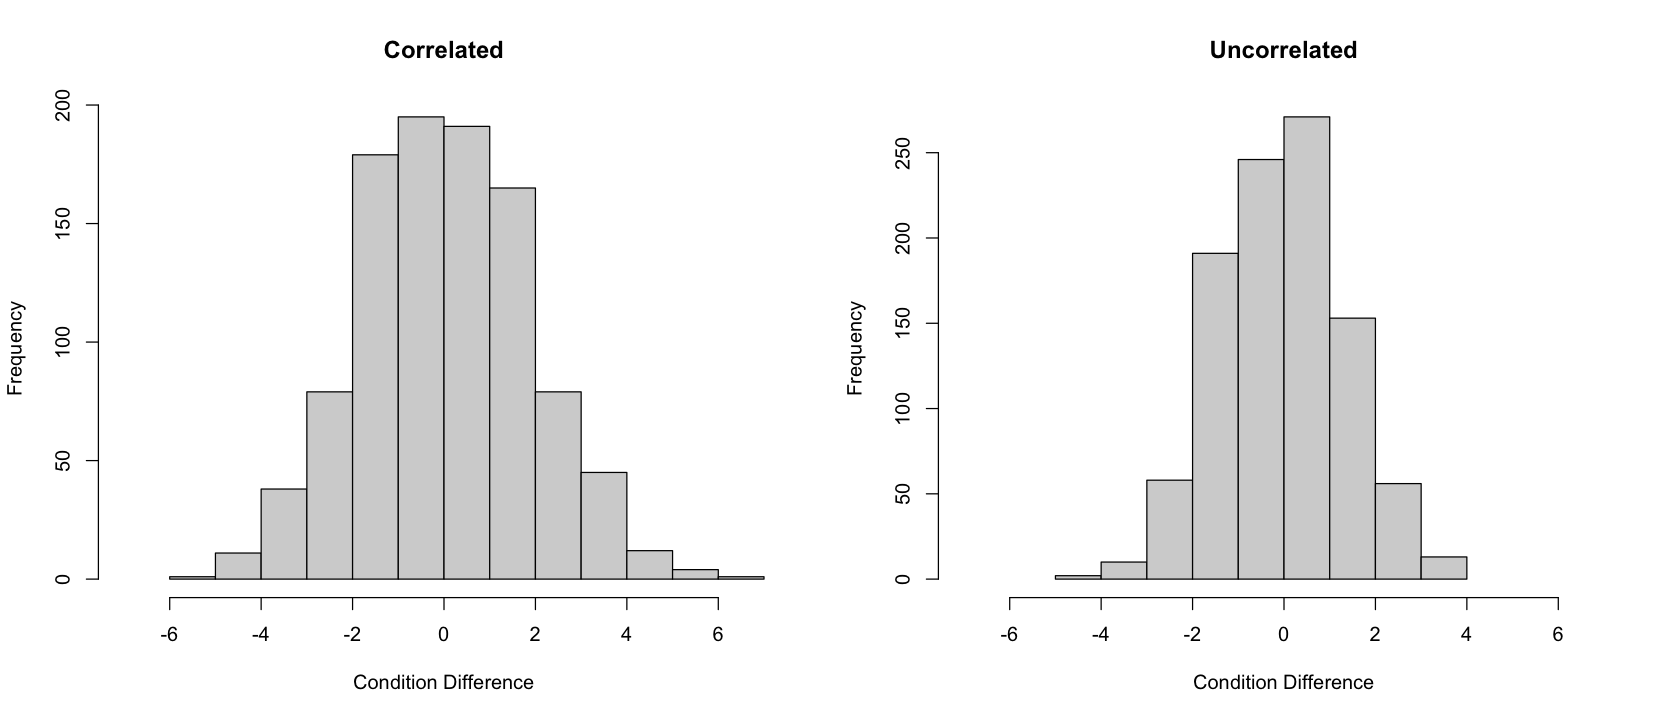

In [27]:
library(MASS)
set.seed(666) # For reproducibility

# Dependent covariance matrix
var1      <- 1             
var2      <- 1             
rho       <- -0.8          
covar     <- rho*sqrt(var1)*sqrt(var2)
Sigma_dep <- matrix(c(var1,covar,covar,var2),2,2)

# Independent covariance matric
rho         <- 0             
covar       <- rho*sqrt(var1)*sqrt(var2)
Sigma_indep <- matrix(c(var1,covar,covar,var2),2,2)

# Sample data
y_dep   <- mvrnorm(n=1000, mu=c(0,0), Sigma=Sigma_dep)
y_indep <- mvrnorm(n=1000, mu=c(0,0), Sigma=Sigma_indep)

# Differences
y_diff_dep   <- y_dep[,1]   - y_dep[,2]
y_diff_indep <- y_indep[,1] - y_indep[,2]

# Plot histograms of differences
par(mfrow=c(1,2))
hist(y_diff_dep,   xlim=c(-7,7), xlab='Condition Difference', main='Correlated')
hist(y_diff_indep, xlim=c(-7,7), xlab='Condition Difference', main='Uncorrelated')

In [29]:
SE_dep_theory <- sqrt(1 + 1 - 2*(-0.8)) # Theoretical SE
SE_dep_est    <- sd(y_diff_dep)         # Estimated SE from simulation

round(c(SE_dep_theory, SE_dep_est), digits=3)

[1] 1.897 1.867

In [31]:
SE_indep_theory <- sqrt(1 + 1 - 2*0) # Theoretical SE
SE_indep_est    <- sd(y_diff_indep)  # Estimated SE from simulation

round(c(SE_indep_theory, SE_indep_est), digits=3)

[1] 1.414 1.364

## Take-home Message

```{admonition} Take Home Message
Dependence influences the magnitude of the standard errors when comparing correlated measurements. This has two important ramifications:

1. When designing an experiment, we can improve power by using repeated measurements, so long as the correlation is *positive*.
2. When analysing data, it is important that this correlation is taken into account so that the standard errors are accurate. Depending upon the nature of the dependency, they will either be *smaller* or *larger* than under independent conditions.


```

[^foot1]: For the purpose of this simulation, the fact that there is no mean difference does not matter. All this influences is what number the distribution of differences is centred-on.